# Adversarial AttacksAnd Interpretability Covid Chestxray Dataset

Final Project - Cognitive Computing and Artificial Intelligence - UniCT a.a 2019/2020

*   Raiti Mario O55000434
*   Sortino Renato O55000405
*   Nardo Gabriele Salvatore O55000430

## Import Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os, random, torch, time, copy
import torch.nn.functional as F
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset
from PIL import Image, ImageOps, ImageFilter
from skimage.filters import threshold_local
from torch.autograd import Variable

In [2]:
!pip install captum

     |████████████████████████████████| 1.4MB 10.7MB/s 


## Enable Cuda for GPU computing

In [3]:
import torch
# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Create paths

In [4]:
# dataset_path = './dataset'
from os import path
from google.colab import drive
drive.mount("/content/drive")
covid_dataset_path = "/content/drive/My Drive/Covid_Chestray_Dataset"
#covid_dataset_path = "/content/drive/.shortcut-targets-by-id/1jrhnTdvTCvooz8T_SbI3qAsDLr08pKrk/Covid_Chestray_Dataset/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Creating a Dataset

In [5]:
classes = ['no-covid', 'covid']

In [6]:
class image_dataset(Dataset):
    """Class creator for the x-ray dataset."""

    def __init__(self, csv_path, root_dir, transform=None, phase=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = pd.read_csv(csv_path)
        self.root_dir = root_dir
        self.transform = transform
        # If not a PA view, drop the line 
        self.df.drop(self.df[self.df.view != 'PA'].index, inplace=True)
        self.phase = phase

    def __len__(self):
        
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        if self.df['finding'].iloc[idx] != 'COVID-19':
            finding = 0
            img_path = os.path.sep.join([covid_dataset_path, 'images', self.df['filename'].iloc[idx]])
            image = Image.open(img_path)
            sample = {'image': image, 'finding': finding}
            
            if self.transform:
                sample = {'image': self.transform[self.phase](sample['image']), 'finding': finding}

        else:
            finding = 1
            img_path = os.path.sep.join([covid_dataset_path, 'images', self.df['filename'].iloc[idx]])
            image = Image.open(img_path)
            sample = {'image': image, 'finding': finding}

            if self.transform:
                sample = {'image': self.transform[self.phase](sample['image']), 'finding': finding}

        return sample

## Creating the data transformations

In [7]:
class HistEqualization(object):
    """Image pre-processing.

    Equalize the image historgram
    """
    
    def __call__(self,image):
        
        return ImageOps.equalize(image, mask = None) 

In [8]:
class ContrastBrightness(object):
    """Image pre-processing.

    alpha = 1.0 # Simple contrast control [1.0-3.0]
    beta = 0    # Simple brightness control [0-100]
    """
    
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta
    
    def __call__(self,image,):
        image = np.array(image)
        for y in range(image.shape[0]):
            for x in range(image.shape[1]):
                image[y,x] = np.clip(self.alpha*image[y,x] + self.beta, 0, 255)

                return Image.fromarray(np.uint8(image)*255)

In [9]:
class SmoothImage(object):
    """Image pre-processing.

    Smooth the image
    """
    def __call__(self,image):
        
        return image.filter(ImageFilter.SMOOTH_MORE)

In [10]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(3),
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.Resize(240),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        ContrastBrightness(1.2,25),
        HistEqualization(),
        SmoothImage(),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],
                             [0.25,0.25,0.25])
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(3),
        transforms.Resize(240),
        transforms.CenterCrop(224),
        ContrastBrightness(1.2,25),
        HistEqualization(),
        SmoothImage(),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],
                             [0.25,0.25,0.25])
    ]),
}

## Create a train, validation and test dataset and the dataloaders

In [11]:
from torch.utils.data import DataLoader, Subset
# Import images as Dataset
image_datasets = {
    x: image_dataset(
        csv_path=os.path.sep.join([covid_dataset_path, 'metadata.csv']),
        root_dir=covid_dataset_path,
        transform=data_transforms,
        phase=x)
    for x in ['train', 'test']
}

In [12]:
"""Ratio Train -> 70%, Val -> 15%, Test -> 15%"""
total_len = len(image_datasets['train'])

# Fractions
train_frac = 0.7
val_frac = 0.15
test_frac = 0.15
# Compute number of samples
num_train = int(total_len * train_frac)
num_val = int(total_len * val_frac)
num_test = int(total_len * test_frac)
# Indexes 
indexes = list(range(total_len))
# Split training set
train_idx = indexes[:num_train]
val_idx = indexes[num_train : num_train + num_val]
test_idx = indexes[num_train + num_val:]

In [13]:
#Create train , val and test dataset and loaders as subset of image dataset
train_dataset = Subset(image_datasets['train'], train_idx)
val_dataset = Subset(image_datasets['test'], val_idx)
test_dataset = Subset(image_datasets['test'], test_idx)

train_loader = DataLoader(train_dataset, batch_size=4, num_workers=4, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=4, num_workers=4, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=4, num_workers=4, shuffle=False)

loaders = {"train": train_loader,
           "val": val_loader,
           "test": test_loader}

dataset_sizes = {x: len(loaders[x].dataset) for x in ['train', 'val', 'test']}

In [14]:
print(dataset_sizes)

{'train': 212, 'val': 45, 'test': 46}


## Create a train method

In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, device='cpu'):
    """
    Support function for model training.

    Args:
      model: Model to be trained
      criterion: Optimization criterion (loss)
      optimizer: Optimizer to use for training
      scheduler: Instance of ``torch.optim.lr_scheduler``
      num_epochs: Number of epochs
      device: Device to run the training on. Must be 'cpu' or 'cuda'
    """
    since = time.time()

    #best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0


    try:
      for epoch in range(num_epochs):
          sum_loss = {"train": 0, "val": 0, "test": 0}
          sum_accuracy = {"train": 0, "val": 0, "test": 0}
          print('Epoch {}/{}'.format(epoch+1, num_epochs))
          print('-' * 10)

          # Each epoch has a training and validation phase
          for phase in ['train', 'val', 'test']:
              if phase == 'train':
                  model.train()  # Set model to training mode
              else:
                  model.eval()   # Set model to evaluate mode

              # Iterate over data.
              for data in loaders[phase]:
                  inputs = data['image']
                  labels = data['finding']
                  inputs = inputs.to(device)
                  labels = labels.to(device)
                  # zero the parameter gradients
                  optimizer.zero_grad()
                  # forward
                  # track history if only in train
                  #with torch.set_grad_enabled(phase == 'train'):
                  outputs = model(inputs)
                  _, preds = torch.max(outputs, 1)

                  loss = criterion(preds.float(), labels.float())
                  loss = Variable(loss, requires_grad = True)
                  # backward + optimize only if in training phase
                  if phase == 'train':
                      loss.backward()
                      optimizer.step()
                  # statistics
                  sum_loss[phase] += loss.item() * inputs.size(0)              
                  sum_accuracy[phase] += torch.sum(preds == labels.data)

              if phase == 'train' and scheduler is not None:
                  scheduler.step()

              epoch_loss = sum_loss[phase] / dataset_sizes[phase]
              epoch_acc = sum_accuracy[phase].double() / dataset_sizes[phase]
              print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
              # deep copy the model
              if phase == 'val' and epoch_acc > best_acc:
                  best_acc = epoch_acc
                  #best_model_wts = copy.deepcopy(model.state_dict())

          epoch_loss_phase = {split: sum_loss[split]/dataset_sizes[split] for split in ["train", "val", "test"]}
          epoch_accuracy_phase = {split: sum_accuracy[split].double()/dataset_sizes[split] for split in ["train", "val", "test"]}  

          for split in ["train", "val", "test"]:
            history_loss[split].append(epoch_loss_phase[split])
            history_accuracy[split].append(epoch_accuracy_phase[split])
          print('-' * 30)
    except KeyboardInterrupt:
      print(f"Computation Stopped at epoch : {epoch+1}")
    except Exception as e:
      print(e)
    finally:
      time_elapsed = time.time() - since
      print("-----------------------------------------")
      print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
      print('Best validation Acc: {:4f}'.format(best_acc))
      # load best model weights
      #model.load_state_dict(best_model_wts)
      return model

## CNNs for classification

### Case 1 : From scratch model

## Case 1: From Scratch model training

### Define Model

In [16]:
# Imports
import torch.nn as nn
import torch.nn.functional as F

# Define model
class ModelFromScratch(nn.Module):
    def __init__(self):
        
        super().__init__();

        self.conv_layers = nn.Sequential(
            # Layer 1
            nn.Conv2d(3, 64, kernel_size=3, padding=0, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            # Layer 2
            nn.Conv2d(64, 128, kernel_size=3, padding=0, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            # Layer 3
            nn.Conv2d(128, 128, kernel_size=3, padding=0, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Layer 4
            nn.Conv2d(128, 256, kernel_size=3, padding=0, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Layer 5
            nn.Conv2d(256, 256, kernel_size=5, padding=0, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=4, stride=2),
            # Layer 6
            nn.Conv2d(256, 512, kernel_size=5, padding=0, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=4, stride=2),
        )

        self.fc_layers = nn.Sequential(
            # FC layer
            nn.Linear(512, 256),
            nn.Dropout(0.5),
            nn.ReLU(),
            # Classification layer
            nn.Linear(256, len(classes))
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [17]:
# Create model
model_fs = ModelFromScratch()

# Test model output
model_fs.eval()
print(train_dataset.dataset)
test_input = train_dataset[0]['image'].unsqueeze(0)

print("Model output size:", model_fs(test_input).size())

# Move model to device
model_fs = model_fs.to(device)

Model output size: torch.Size([1, 2])


### Train model

In [18]:
#criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()

# Note that we are only training the head.
optimizer_ft = optim.Adam(model_fs.parameters(), lr=1e-4)

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.3)

In [19]:
history_loss = {"train": [], "val": [], "test": []}
history_accuracy = {"train": [], "val": [], "test": []}

In [20]:
model_fs_trained = train_model(model_fs.to(device), criterion, optimizer_ft, None ,num_epochs=50, device=device)

Epoch 1/50
----------
train Loss: 0.6288 Acc: 0.5189
val Loss: 0.8101 Acc: 0.4000
test Loss: 0.7984 Acc: 0.4348
------------------------------
Epoch 2/50
----------
train Loss: 0.6294 Acc: 0.5142
val Loss: 0.6950 Acc: 0.6889
test Loss: 0.7258 Acc: 0.5435
------------------------------
Epoch 3/50
----------
Computation Stopped at epoch : 3
-----------------------------------------
Training complete in 1m 22s
Best validation Acc: 0.688889


In [ ]:
torch.cuda.empty_cache() 

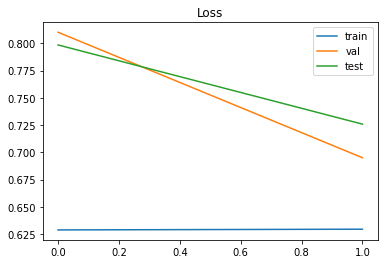

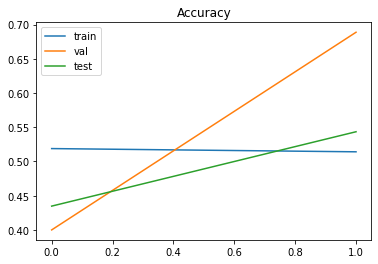

In [21]:
# Plot loss history
plt.title("Loss")
for split in ["train", "val", "test"]:
  plt.plot(history_loss[split], label=split)
plt.legend()
plt.show()

# Plot accuracy history
plt.title("Accuracy")
for split in ["train", "val", "test"]:
  plt.plot(history_accuracy[split], label=split)
plt.legend()
plt.show()

### Model Evaluation

In [28]:
# Evaluate the model 
print("Evaluation Metrics :")
testAccuracy(model_fs_trained,loaders,device)
print("-"*30)
testCovid(model_fs_trained,loaders,device)
print("-"*30)

Evaluation Metrics :
Accuracy of the network: 54 %
------------------------------
Accuracy of no-covid : 50 %
Accuracy of covid : 58 %
------------------------------


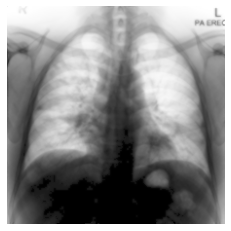

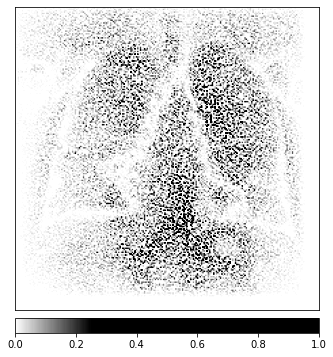

In [31]:
attr = modelInterpretation(device,model_fs_trained)

### Adversarial attack FGSM

In [32]:
attack_test_loader  = DataLoader(test_dataset,  batch_size=1, num_workers=4, shuffle=False)

In [33]:
epsilons = [0, .05, .1, .15, .2, .25, .3]

In [34]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [35]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for datas in test_loader:

        data = datas['image']
        target = datas['finding']

        # Send the data and label to the device
        data, target = data.to(device).requires_grad_(), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {:.4f}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [36]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model_fs_trained, device, attack_test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 11 / 46 = 0.2391
Epsilon: 0.05	Test Accuracy = 10 / 46 = 0.2174
Epsilon: 0.1	Test Accuracy = 14 / 46 = 0.3043
Epsilon: 0.15	Test Accuracy = 17 / 46 = 0.3696
Epsilon: 0.2	Test Accuracy = 17 / 46 = 0.3696
Epsilon: 0.25	Test Accuracy = 16 / 46 = 0.3478
Epsilon: 0.3	Test Accuracy = 15 / 46 = 0.3261


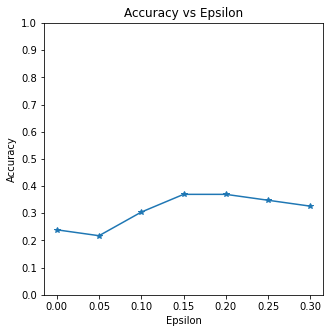

In [37]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

## Case 2 : Adversarial Training

### Adversarial Dataset

### Training and Fine tuning

In [ ]:
#criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()

# Note that we are only training the head.
optimizer_ft = optim.Adam(model_fs.parameters(), lr=1e-4)

In [ ]:
history_loss = {"train": [], "val": [], "test": []}
history_accuracy = {"train": [], "val": [], "test": []}

In [ ]:
model_fs_attack = train_model(model_fs_trained.to(device), criterion, optimizer_ft, None ,num_epochs=50, device=device)

### Model Evaluation

In [ ]:
# Evaluate the model 
print("Evaluation Metrics :")
testAccuracy(model_fs_attack,loaders,device)
print("-"*30)
testCovid(model_fs_attack,loaders,device)
print("-"*30)

In [ ]:
attr_attack = modelInterpretation(device,model_fs_attack)

## Adversarial Image Creation

In [63]:
from torchvision.utils import save_image

epsilon = 0.025
covid_adv_path = path.join("/content/drive/My Drive/", "Covid_Chestray_Dataset_Adversarial/adv_images")

image_dataset_train = image_dataset(
        csv_path=os.path.sep.join([covid_dataset_path, 'metadata.csv']),
        root_dir=covid_dataset_path,
        transform= {'train': transforms.Compose([
          transforms.Grayscale(3),
          transforms.Resize(240),
          transforms.CenterCrop(224),
          transforms.ToTensor(),
    ])},
        phase='train')

train_dataset = Subset(image_dataset_train, train_idx)
train_loader = DataLoader(train_dataset, batch_size=1, num_workers=4, shuffle=True)
len(train_loader)

212

In [90]:
metadata_path = path.join("/content/drive/My Drive/", "Covid_Chestray_Dataset_Adversarial/adv_metadata.csv")

df = pd.DataFrame([], columns=['filename', 'finding'])


In [91]:
for i, datas in enumerate(train_loader):

    data = datas['image']
    target = datas['finding']

    # Send the data and label to the device
    data, target = data.to(device).requires_grad_(), target.to(device)

    # Set requires_grad attribute of tensor. Important for Attack
    data.requires_grad = True

    # Forward pass the data through the model
    output = model_fs_trained(data)

    # Calculate the loss
    loss = F.nll_loss(output, target)

    # Zero all existing gradients
    model_fs_trained.zero_grad()

    # Calculate gradients of model in backward pass
    loss.backward()

    # Collect datagrad
    data_grad = data.grad.data

    # Call FGSM Attack
    perturbed_data = fgsm_attack(data, epsilon, data_grad)
    img_name = "adv_img" + str(i) + ".png"

    if target == 0:
      finding = 'COVID-19'
    else:
      finding = 'NO-COVID-19'

    new_row = {'filename': img_name, 'finding':finding}
    df = df.append(new_row, ignore_index=True)

    save_image(perturbed_data, path.join(covid_adv_path, img_name))
df.to_csv(metadata_path)

## Interpretability Function

In [24]:
def modelInterpretation(device,model):
  # Model interpretability
  import random
  from captum.attr import IntegratedGradients
  from captum.attr import visualization as viz
  from matplotlib.colors import LinearSegmentedColormap
  %matplotlib inline

  # Get random sample from test set
  idx = random.randint(0, dataset_sizes['test']-1)
  input, label = loaders['test'].dataset[idx]['image'], loaders['test'].dataset[idx]['finding']
  # Normalize and show image
  input_show = (input - input.min())/(input.max() - input.min())
  plt.imshow(input_show.permute(1,2,0).numpy())
  plt.axis('off')
  # Predict class
  model.eval()
  output = model(input.unsqueeze(0).to(device))
  _,pred = output.max(1)
  pred = pred.item()
  output_probs = F.softmax(output, dim=1)

  integrated_gradients = IntegratedGradients(model.to(device))
  input = input.to(device)

  attributions_ig = integrated_gradients.attribute(input.unsqueeze(0).to(device), target=pred)

  default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                  [(0, '#ffffff'),
                                                    (0.25, '#000000'),
                                                    (1, '#000000')], N=256)

  _= viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                              np.transpose(input.squeeze().cpu().detach().numpy(), (1,2,0)),
                              method='heat_map',
                              cmap=default_cmap,
                              show_colorbar=True,
                              sign='positive',
                              outlier_perc=1)
  return attributions_ig

## Evaluation Functions

In [67]:
def testAccuracy(model,loaders,device):
  correct = 0
  total = 0
  with torch.no_grad():
      for data in loaders['test']:
          inputs = data['image']
          labels = data['finding']
          outputs = model(inputs.float().to(device))
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels.to(device)).sum().item()

  print('Accuracy of the network: %d %%' % (100 * correct / total))

In [66]:
def testCovid(model,loaders,device):
  class_correct = list(0. for i in range(2))
  class_total = list(0. for i in range(2))

  with torch.no_grad():
      for data in loaders['test']:
          images = data['image']
          labels = data['finding']
          outputs = model(images.to(device))
          _, predicted = torch.max(outputs, 1)
          c = (predicted == labels.to(device))
          for i in range(images.shape[0]):
              label = labels[i]
              class_correct[label] += c[i].item()
              class_total[label] += 1

  for i in range(2):
      print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

In [65]:
def confusionMatrix(model): 
  from sklearn.metrics import confusion_matrix

  dataloader = torch.utils.data.DataLoader(image_datasets['test'], batch_size=(len(image_datasets['test'])), num_workers=8)

  dataiter = iter(dataloader)
  data = dataiter.next()
  images = data['image']
  labels = data['finding']

  model.to('cpu')

  output = torch.tensor(model(images).detach().numpy())

  # compute the confusion matrix and and use it to derive the raw
  # accuracy, sensitivity, and specificity
  cm = confusion_matrix(labels, np.argmax(output,1))
  total = sum(sum(cm))
  acc = (cm[0, 0] + cm[1, 1]) / total
  sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
  specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
  # show the confusion matrix, accuracy, sensitivity, and specificity
  print("Confusion Matrix : ")
  print(cm)
  print("acc: {:.4f}".format(acc))
  print("sensitivity: {:.4f}".format(sensitivity))
  print("specificity: {:.4f}".format(specificity))